In [1]:
import geopandas
import starepandas
import pystare
import numpy
import matplotlib.pyplot as plt
import pickle

In [2]:
# We set level to 15 because that appears to be matching VNP02 nadir resolution 
level = 15

In [3]:
caribbean = geopandas.read_file('study_area_fao_clean_210326.gpkg')

In [4]:
country = caribbean[caribbean['ADM0_NAME']=='Dominica']

In [5]:
country = starepandas.STAREDataFrame(country, add_stare=True, level=level, add_trixels=True)

In [8]:
cover_sids = country.stare_dissolve()
country_cover = starepandas.STAREDataFrame(stare=cover_sids)
country_cover.set_trixels(inplace=True)

In [16]:
print(numpy.concatenate(list(country['stare'])).size)
print(len(cover_sids))

4296
903


<AxesSubplot:>

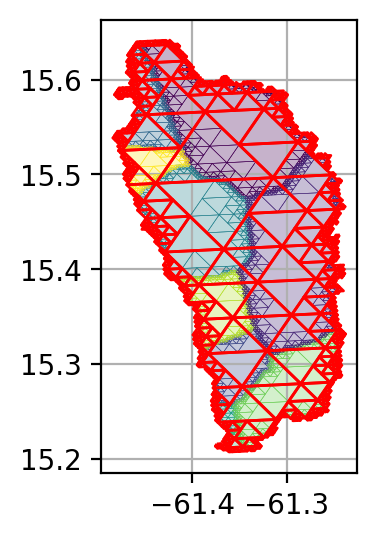

In [21]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

country.plot(ax=ax, trixels=False,  alpha=0.3, column='ADM2_CODE')
country.plot(ax=ax, trixels=True, boundary=True, linewidth=0.2, column='ADM2_CODE')
country_cover.plot(ax=ax, trixels=True, color='red', linewidth=1)

# Make a catalogue and find intersecting granules

In [32]:
path = 'data/'
granule_trunk = 'VNP03DNB'

catalogue = starepandas.folder2catalogue(path=path, 
                                         granule_trunk=granule_trunk,
                                         granule_extension='nc')

In [55]:
intersects = catalogue.stare_intersects(cover_sids)
intersecting = catalogue[intersects]
intersecting

,begining,ending,granule_path,sidecar_path,stare_cover
1,2020-08-21T04:42:00.000Z,2020-08-21T04:48:00.000Z,data/VNP03DNB.A2020234.0442.001.2020234111916.nc,data/VNP03DNB.A2020234.0442.001.2020234111916_...,"[2459106134032646152, 2459117129148923914, 245..."


# Read Granule

In [69]:
# Ouch!!
import glob
geoloc_path = intersecting.iloc[0].granule_path
granule_path = geoloc_path.replace('VNP03', 'VNP02')
granule_path = '.'.join(granule_path.split('.')[0:3]) + '*[!_stare].nc'
granule_path = glob.glob(granule_path)[0]
granule_path

'data/VNP02DNB.A2020234.0442.001.2020234113021.nc'

In [70]:
vnp02 = starepandas.read_granule(granule_path, sidecar=True, read_latlon=True)
vnp02.head()

,lat,lon,stare,DNB_observations,DNB_quality_flags,moon_illumination_fraction,land_water_mask,quality_flag
0,28.386375,-60.319633,2459503361770949326,-9.999000e+02,256,6.24,7,0
1,28.386024,-60.311405,2459503621023984686,-9.603547e-11,0,6.24,7,0
2,28.385674,-60.303181,2459503616710105902,-5.936776e-10,0,6.24,7,0
3,28.385324,-60.294964,2459503730595189102,-7.927342e-10,0,6.24,7,0
4,28.384972,-60.286755,2459503715383870766,-9.603540e-11,0,6.24,7,0


# Filter according to masks and flags

## DNB_quality_flags
- 1     Substitute_Cal 
- 2     Out_of_Range 
- 4     Saturation 
- 8     Temp_not_Nominal 
- 16    Stray_light 
- 256   Bowtie_Deleted 
- 512   Missing_EV 
- 1024  Cal_Fail 
- 2048  Dead_Detector

## land_water_mask
- 0 Shallow Ocean; Ocean pixel with depth < 160 ft
- 1 Land; Land detected
- 2 Shoreline; Last land pixel before water
- 3 Inland Water;  Open surface water on continent
- 4 Ephemeral Water; Not populated in this version
- 5 Deep Inland Water; Inland water > 160 ft
- 6 Moderate Ocean; Ocean pixel with depth > 160 ft but <400 ft
- 7 Deep Ocean; Ocean pixel with depth > 400 ft

## quality_flag (geolocation)
- 1: Input_invalid
- 2: Pointing_bad
- 3: Terrain_bad

In [24]:
mask = vnp02['DNB_quality_flags'] == 0
mask &= vnp02['quality_flag'] == 0
mask &= (vnp02['land_water_mask'] == 1) | (vnp02['land_water_mask'] == 2)

In [25]:
selected = vnp02[mask]
print('{} %'.format(round(selected.size/vnp02.size*100)))

2 %


# Pulling out data intersecting our ROI

In [71]:
selected = starepandas.STAREDataFrame(selected, geometry=pts)

In [76]:
intersected = selected[selected.stare_intersects(cover_sids)]
intersected.head()

,lat,lon,stare,DNB_observations,DNB_quality_flags,moon_illumination_fraction,land_water_mask,quality_flag,geometry
8050881,15.637018,-61.458786,2521989540800107405,3.647404e-11,0,6.22,2,0,POINT (-61.45879 15.63702)
8050882,15.636107,-61.448864,2521991330543404013,1.263103e-10,0,6.22,2,0,POINT (-61.44886 15.63611)
8050883,15.635323,-61.440296,2521990247527019981,-1.431984e-10,0,6.22,2,0,POINT (-61.44030 15.63532)
8050884,15.634664,-61.433140,2521990252773254254,-5.336220e-11,0,6.22,2,0,POINT (-61.43314 15.63466)
8050885,15.634069,-61.426731,2521990341373960750,1.263103e-10,0,6.22,2,0,POINT (-61.42673 15.63407)


In [78]:
dnb = intersected['DNB_observations'].mean()
dnb

2.1638884e-10

<AxesSubplot:>

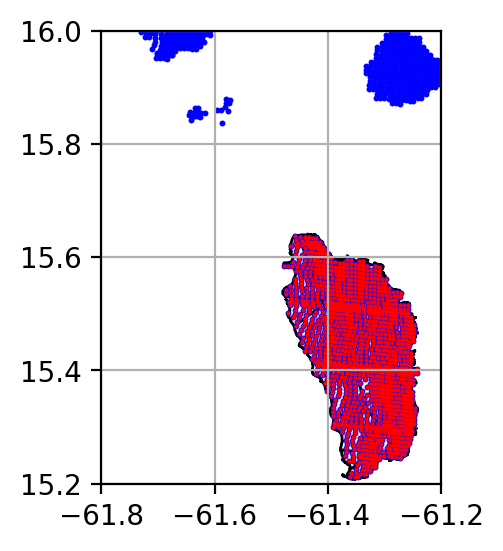

In [73]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

ax.set_ylim(15.2, 16)
ax.set_xlim(-61.8, -61.2)

country.plot(ax=ax, trixels=False, color='w', edgecolor='black')
selected.plot(ax=ax, color='b', marker='.', markersize=5)
intersected.plot(ax=ax, color='r', alpha=1, marker='.', markersize=1)

# Load Cloudmask

## Cloud mask meaning
- 0 = cloudy
- 1 = probably cloudy 
- 2 = probably clear 
- 3 = confident clear
- -1 = no result